# Xin et al 2018 data analysis
## Philipp Burt
### 12.06.2020

# packages

In [1]:
import scanpy as sp
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import seaborn as sb

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


# Xin datalontains 691 cells (barcodes) and 27998 annotated genes
this requires file path to directory with 3 files, barcodes.tsv, genes.tsv, matrix.mtx. note that files have to be named as such because this reflects the output from 10x genomics software cell ranger.

In [2]:
filepath = "C:/Users/Philipp/OneDrive/projects/2020/tcell_scRNAseq/data/xin_2018/"
data_path= "GSE111026_RAW/"
filepath = filepath+data_path

adata = sc.read_10x_mtx(filepath, cache = True)
print(adata)

... reading from cache file cache\C-Users-Philipp-OneDrive-projects-2020-tcell_scRNAseq-data-xin_2018-GSE111026_RAW-matrix.h5ad
AnnData object with n_obs × n_vars = 691 × 27998
    var: 'gene_ids'


# exploratory data analysis shows that data is already processed (e.g. low mito content)
no further filtering steps applied (cell number matches cell number in original paper)

Total number of cells: 691
filtered out 16615 genes that are detected in less than 2 cells
Total number of cells after prefiltering: 691


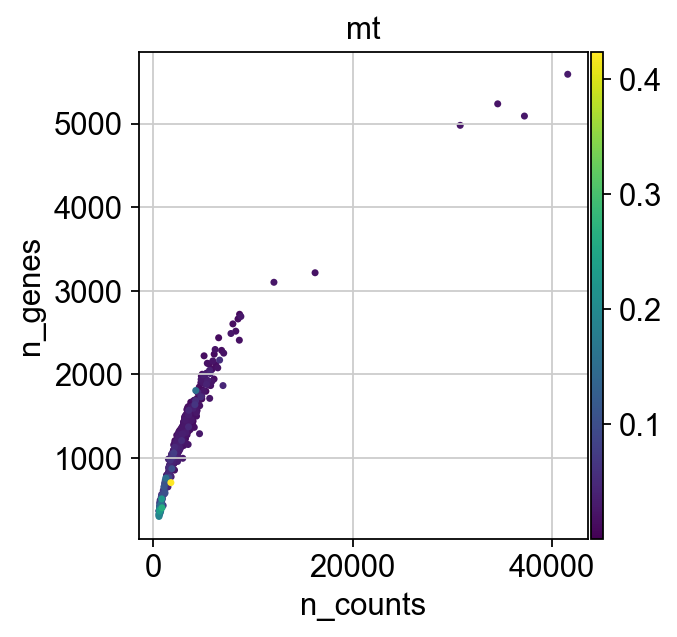

Total number of cells: 691


In [3]:
print('Total number of cells: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = 5)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=2)

# Filter cells according to identified QC thresholds:
print('Total number of cells after prefiltering: {:d}'.format(adata.n_obs))

# add mitochondrial gene fraction, code taken from 10x tutorial scanpy. note that mouse mito genes start as mt-
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']
#Data quality summary plots with mitochondrial gene content as color code
p1 = sc.pl.scatter(adata, x = 'n_counts', y ='n_genes', color = "mt", size=40)

print('Total number of cells: {:d}'.format(adata.n_obs))


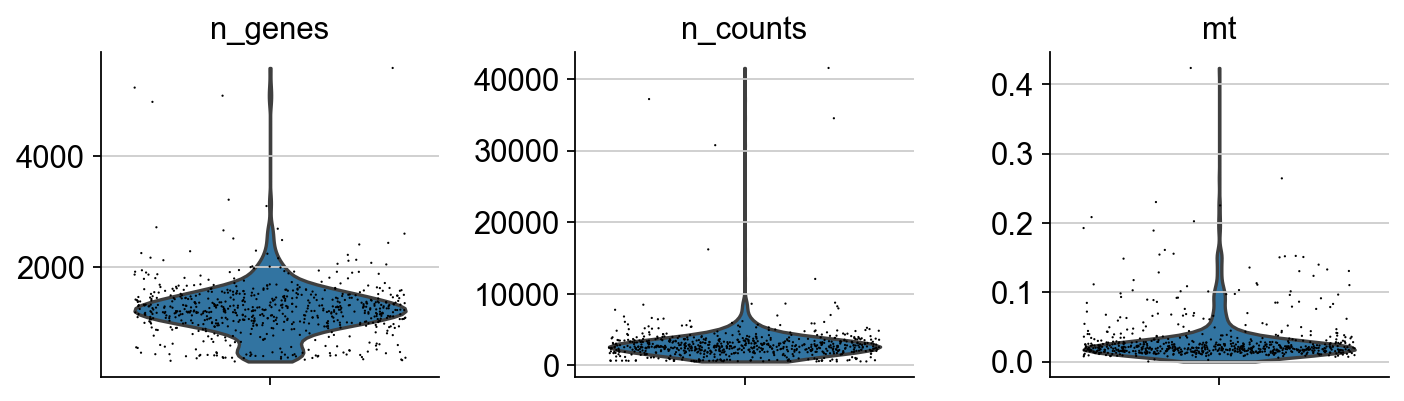

In [4]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt'],
             jitter=0.4, multi_panel=True)

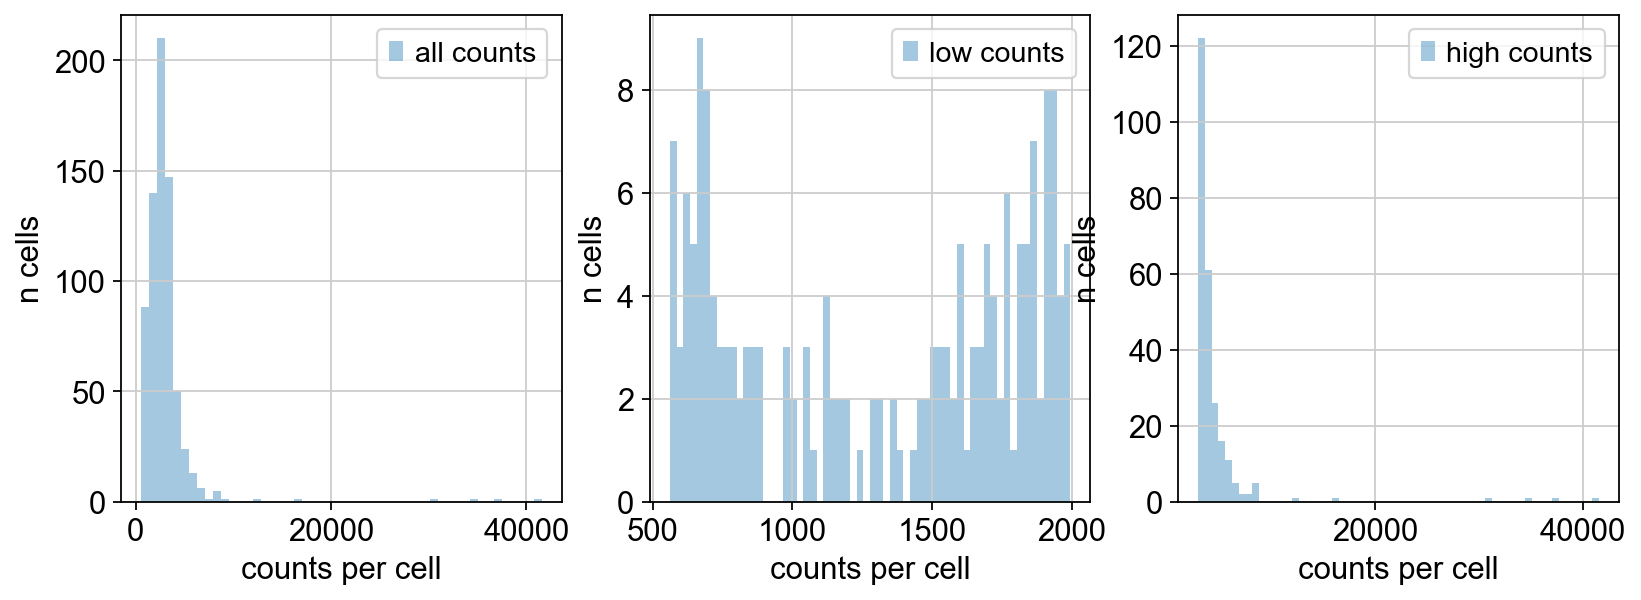

Total number of cells: 691


In [5]:
#filter based on total counts
import seaborn as sns
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

p1 = sns.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=ax1, label = "all counts")
p2 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<2000], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low counts")
p3 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>3000], 
                 kde=False, bins=60, 
                 ax=ax3, label = "high counts")
for ax in [ax1, ax2, ax3]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("counts per cell")
plt.show()

print('Total number of cells: {:d}'.format(adata.n_obs))

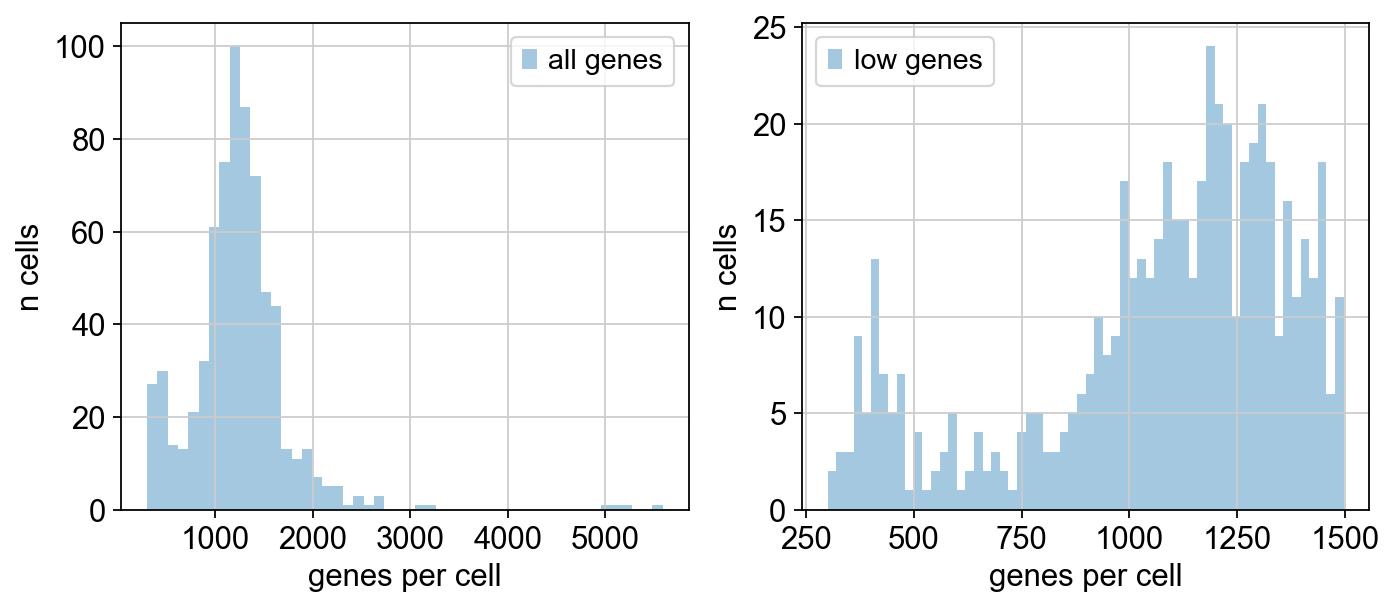

Total number of cells: 691


In [6]:
#filter based on total counts
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

p1 = sns.distplot(adata.obs['n_genes'], 
                 kde=False, 
                 ax=ax1, label = "all genes")
p2 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low genes")

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("genes per cell")
plt.show()

print('Total number of cells: {:d}'.format(adata.n_obs))

In [7]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 15000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

print("note that in original paper they have 628 cells after preprocessing")

Total number of cells: 691
filtered out 66 cells that have less than 1000 counts
Number of cells after min count filter: 625
filtered out 5 cells that have more than 15000 counts
Number of cells after max count filter: 620
Number of cells after gene filter: 620
note that in original paper they have 628 cells after preprocessing


# normalization 

normalizing counts per cell
    finished (0:00:00)


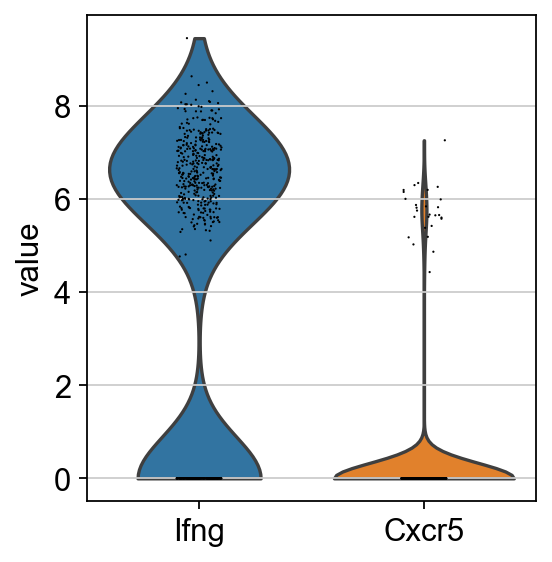

In [8]:
# save data before normalization
savepath = "C:/Users/Philipp/OneDrive/projects/2020/tcell_scRNAseq/output/cleaned_datasets/"
adata.write(savepath+"anndata_filtered_xin_2018.h5ad")

#sc.pl.violin(adata, ["Ifng", "Cxcr5"])

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pl.violin(adata, ["Ifng", "Cxcr5"])

adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


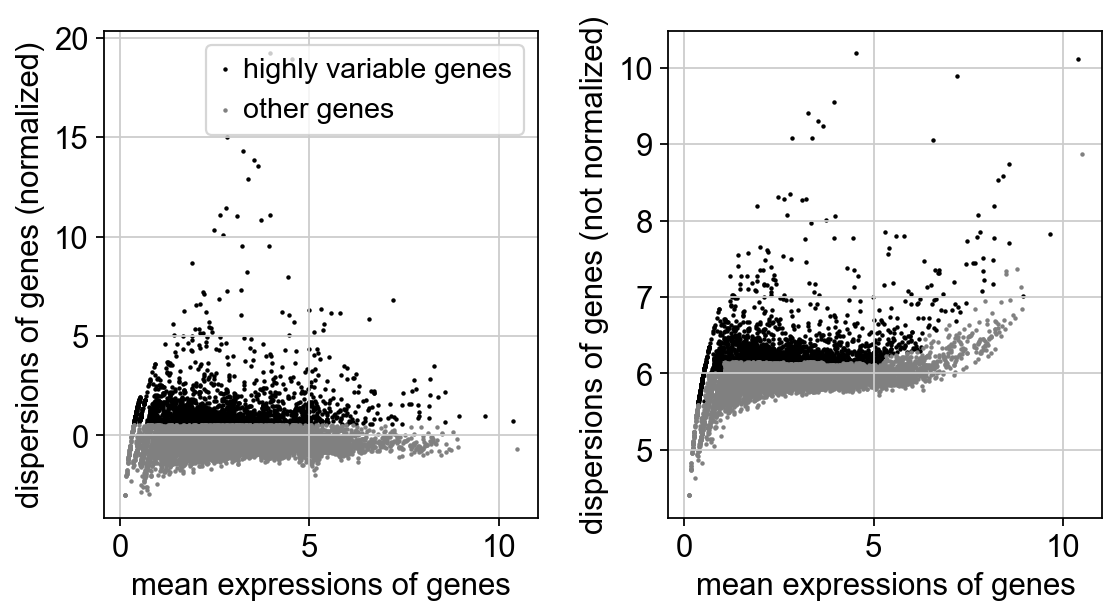

In [9]:
# in original study they use highly variable genes for PCA and clustering but then if I scale it does not
# identify highly variable genes, this is used for PCA later
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
sc.pl.highly_variable_genes(adata)

#sc.pp.scale(adata, max_value=10)

(-5, 20)

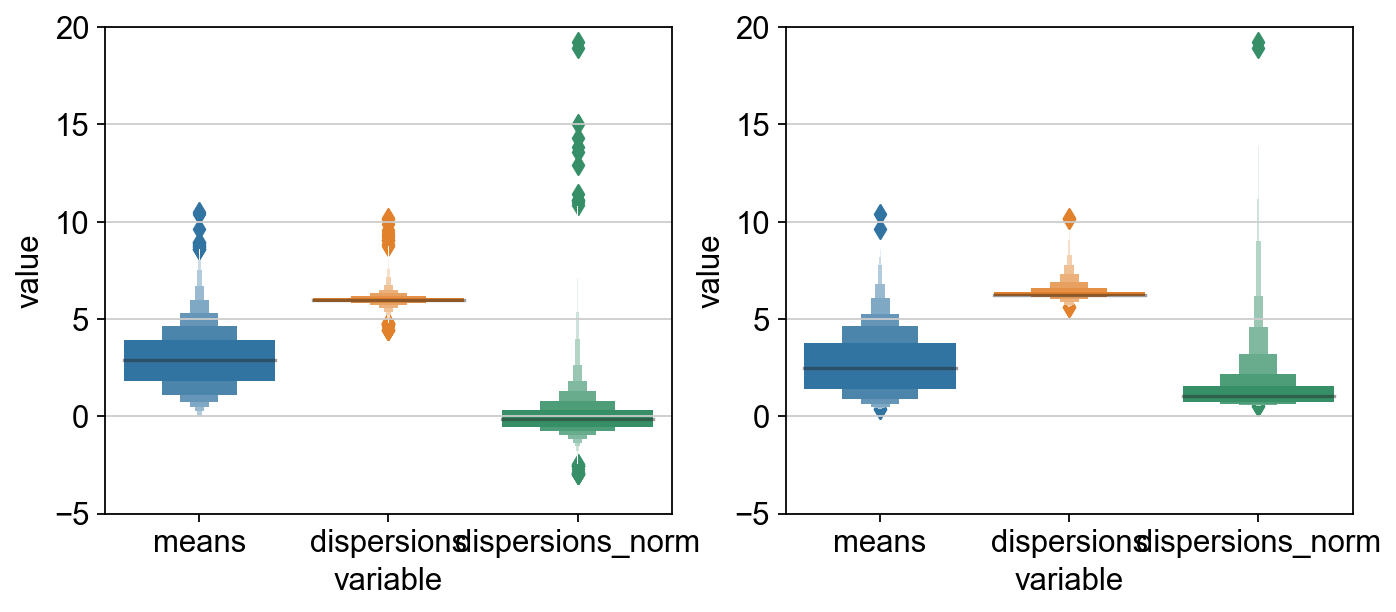

In [11]:
df = adata.var[["highly_variable", "means", "dispersions", "dispersions_norm"]]
df.to_csv("../output/variance_xin_2018.csv")

df2 = df.melt(id_vars = ["highly_variable"])
df_var = df2[df2.highly_variable == True]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
sns.boxenplot(data = df2, x = "variable", y = "value", ax = ax1)
sns.boxenplot(data = df_var, x = "variable", y = "value", ax = ax2)

ylim = (-5,20)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

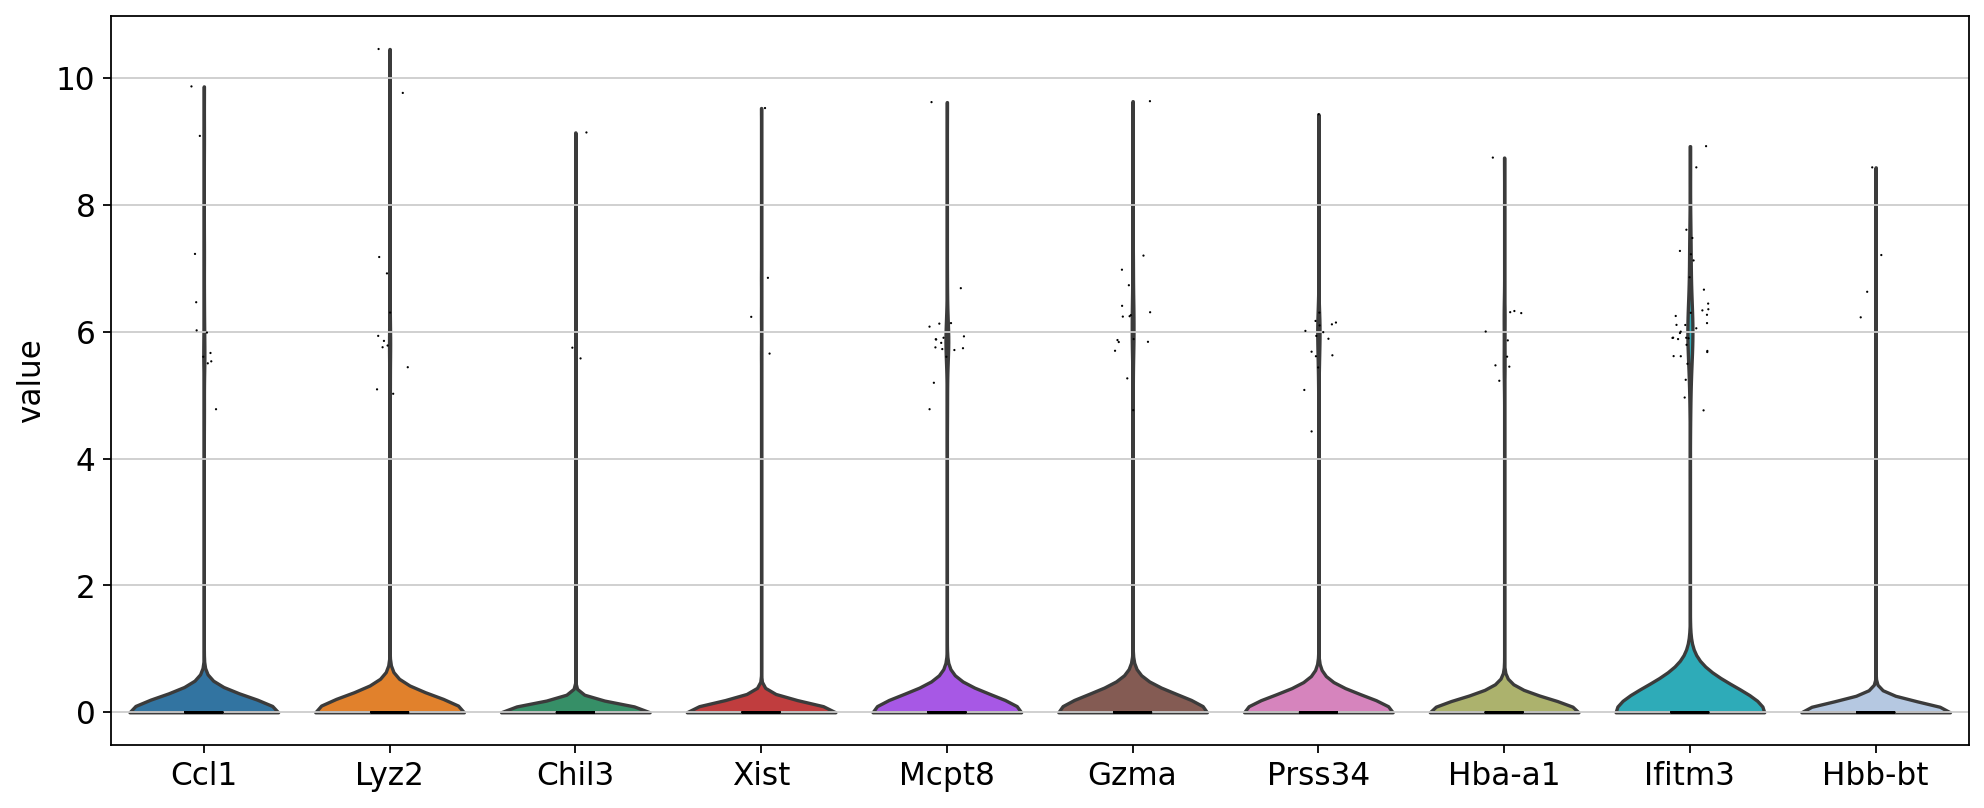

In [20]:
# find the top variable genes
#df.sort_values(by = "dispersions_norm", ascending = False)
#top_var_genes = df.index.values
#top_var_genes = top_var_genes[:10]
df_sorted = df.sort_values(by = "dispersions_norm", ascending = False)
genes_sorted = df_sorted.index.values
top_var_genes = genes_sorted[:10]

rcParams['figure.figsize']=(12,6)
sc.pl.violin(adata, top_var_genes)

# dimensionality reduction

computing PCA
    with n_comps=50
    finished (0:00:01)


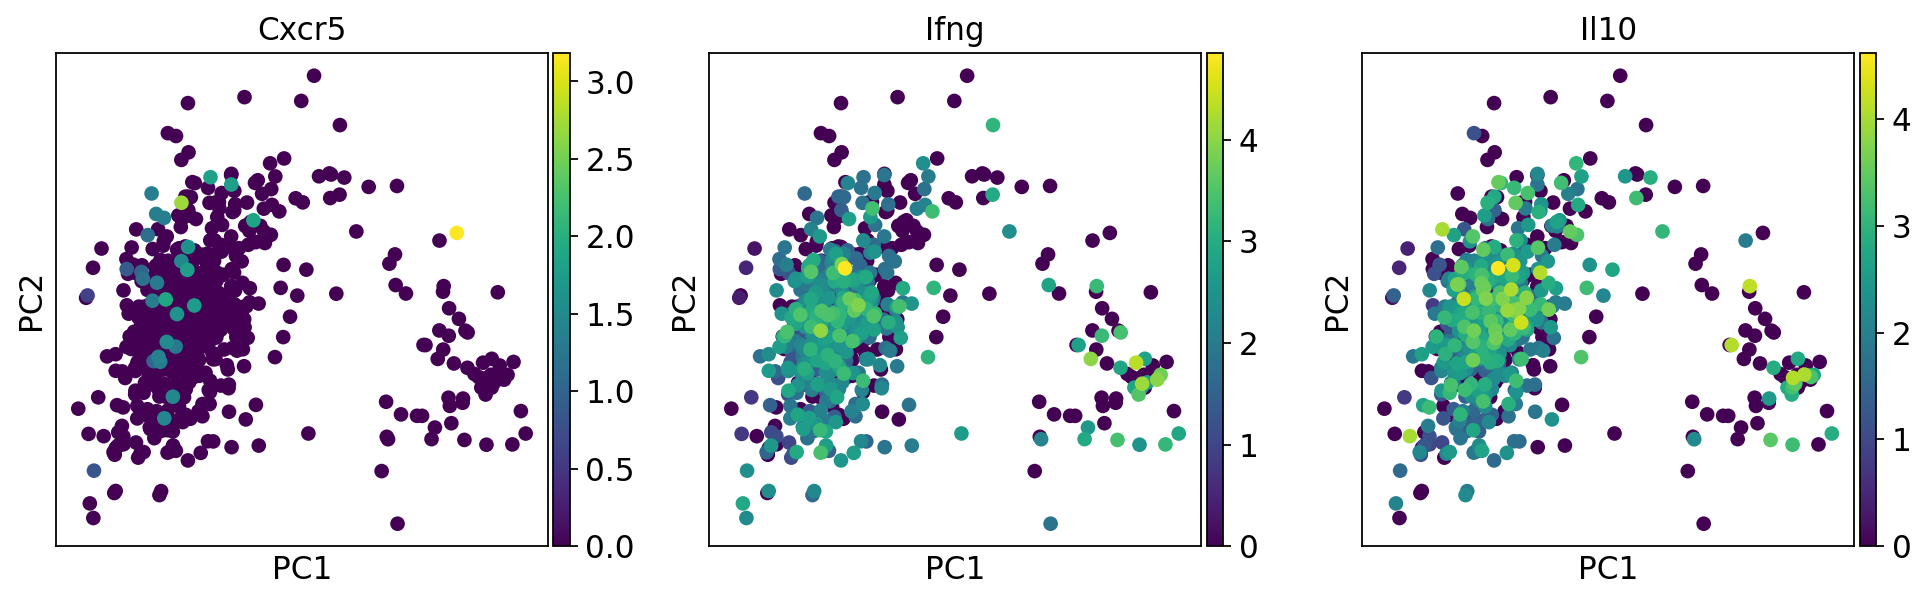

In [49]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = ["Cxcr5", "Ifng", "Il10"])

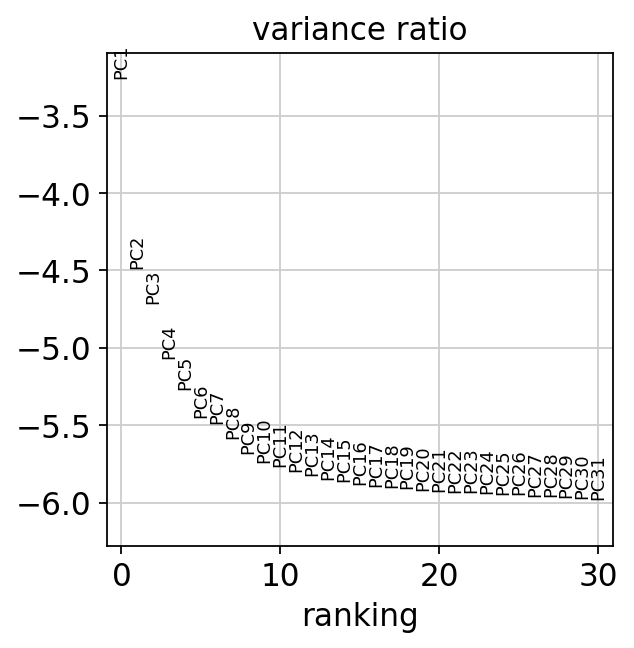

In [48]:
sc.pl.pca_variance_ratio(adata, log=True)


In [50]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


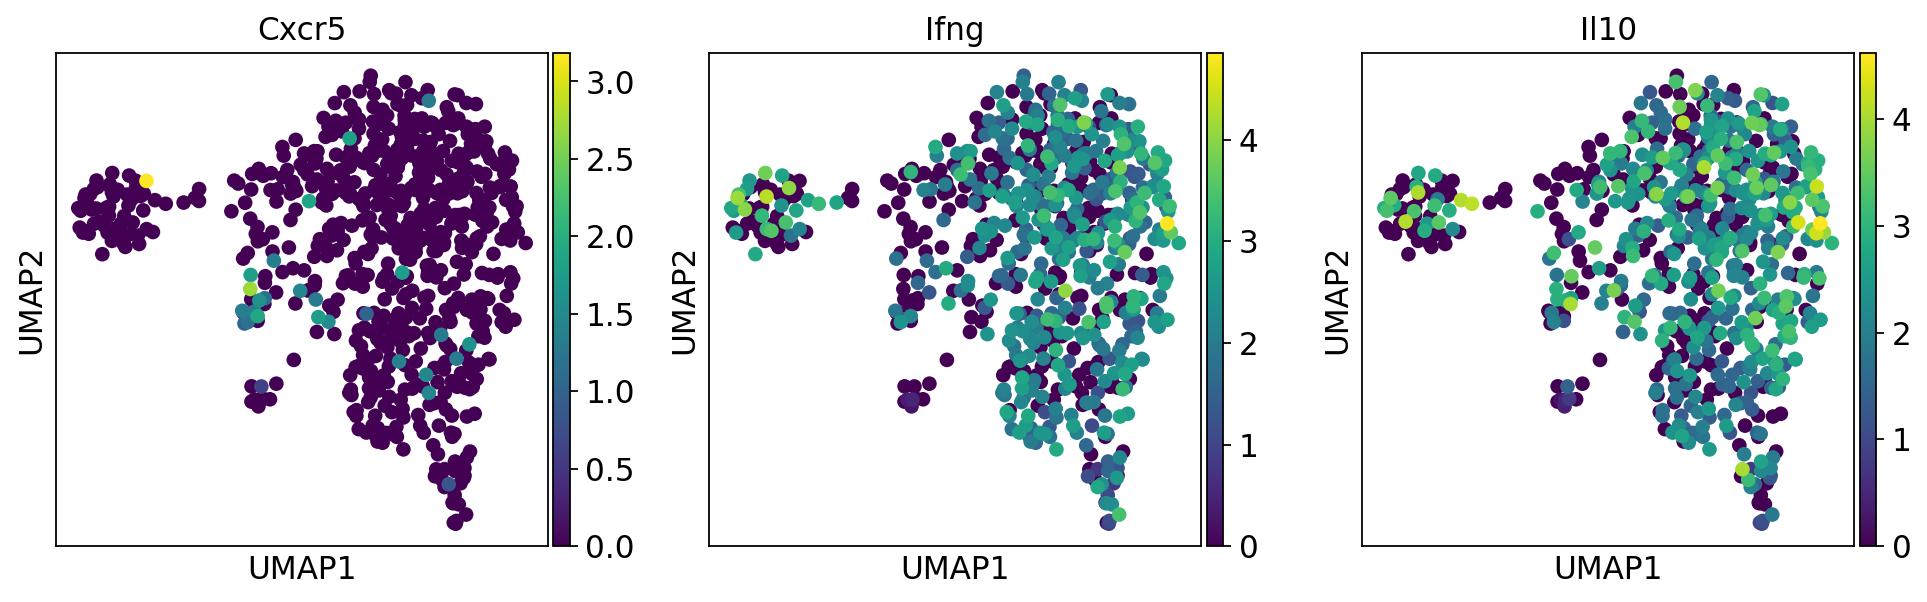

In [53]:
sc.tl.umap(adata)
sc.pl.umap(adata, color= ["Cxcr5", "Ifng", "Il10"])

# clustering

In [54]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


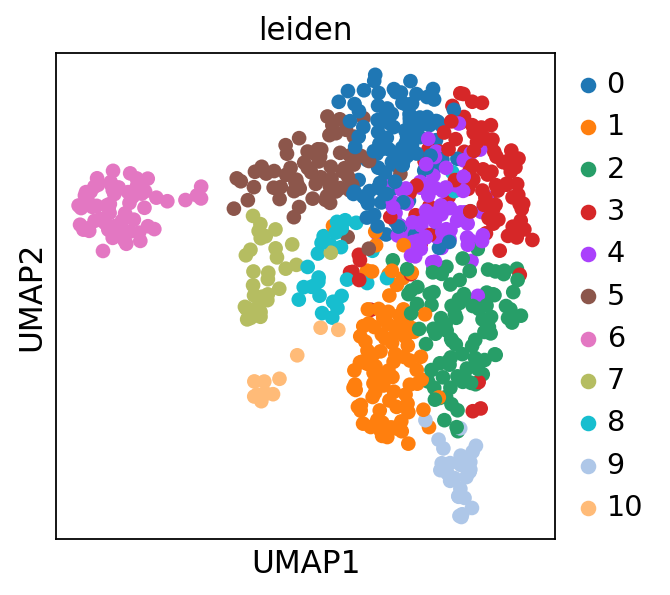

In [56]:
sc.pl.umap(adata, color=['leiden'])